In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.transforms import v2
import torch


IMAGES_PATH = "Tennis Player Actions Dataset for Human Pose Estimation/images"
DATA_SPLIT = [0.8, 0.1, 0.1]
BATCH_SIZE = 32 
MEAN = [126.7874, 129.6748, 120.0113]
STD = [58.5588, 57.8795, 59.8400]
DEGREES = 15
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
NEW_SIZE = (240, 240)
# print(DEVICE)


initial_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=False),
    v2.Normalize(mean=MEAN, std=STD),
    v2.Resize(NEW_SIZE)
])

full_transform = v2.Compose([
    initial_transform,
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(DEGREES),
])

class TransformSubset(Dataset): 
    def __init__(self, subset, transform): 
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)
        

full_dataset = datasets.ImageFolder(root=IMAGES_PATH)
generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset, val_dataset = random_split(full_dataset, DATA_SPLIT, generator=generator)

train_dataset = TransformSubset(train_dataset, full_transform)
test_dataset = TransformSubset(test_dataset, initial_transform)
val_dataset = TransformSubset(val_dataset, initial_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("-"*3, "Number of samples", "-"*3)
print("Training:", len(train_dataset))
print("Testing:", len(test_dataset))
print("Validation:", len(val_dataset))

--- Number of samples ---
Training: 1600
Testing: 200
Validation: 200


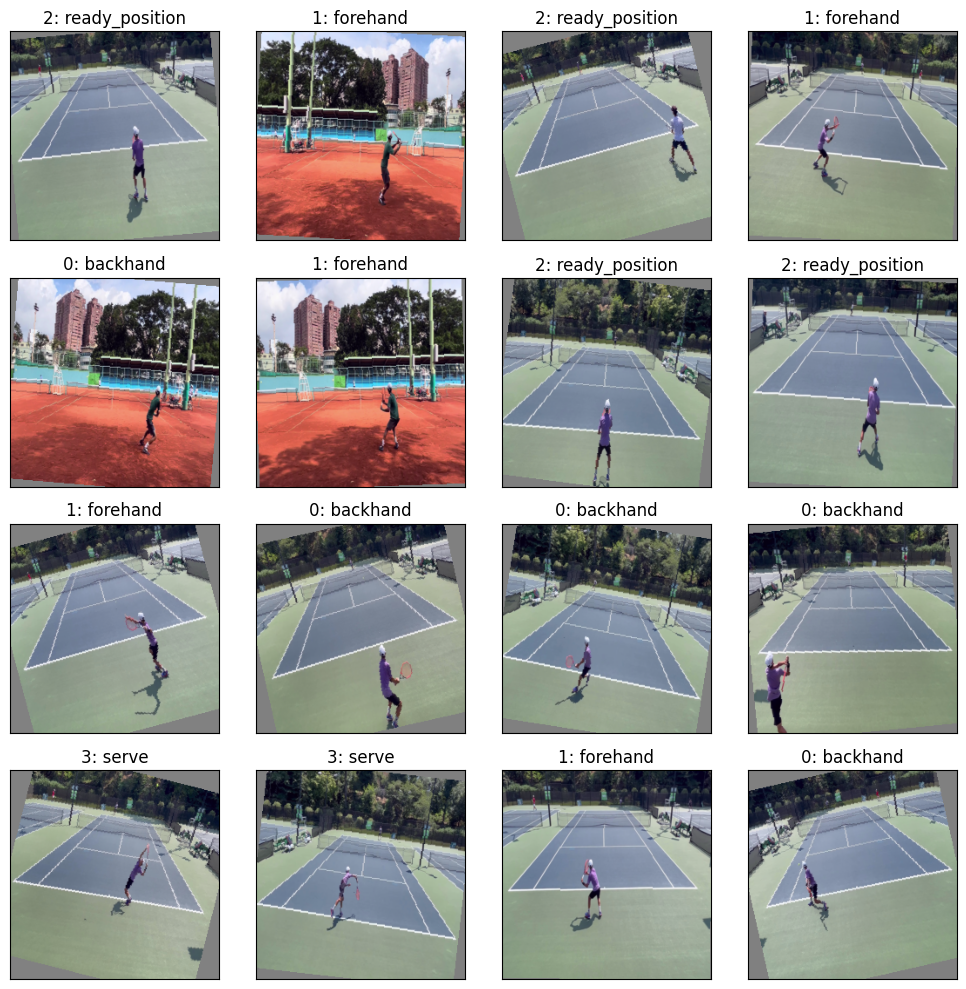

In [4]:
import matplotlib.pyplot as plt
import numpy as np

class_mapping = {
    0: "backhand",
    1: "forehand",
    2: "ready_position",
    3: "serve"
}

def visualize_images(dataloader, num_images = 20):
    fig = plt.figure(figsize=(10,10))

    #Iterate over the first batch
    images, labels = next(iter(dataloader))
    # print(images.shape)

    num_rows = 4
    num_cols = int(np.ceil((num_images / num_rows)))

    for idx in range(min(num_images, len(images))):
        image, label = images[idx], labels[idx]


        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks = [], yticks = [])

        image = image.permute(1,2,0)

        #Normalize the image to [0,1] to display

        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image, cmap="gray")  # remove the batch dimension
        ax.set_title(f"{label.item()}: {class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

visualize_images(train_loader, num_images = 16)

In [39]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.dropout = nn.Dropout(0.3)

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # (3, 240, 240) -> (32, 60, 60)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # (32, 60, 60) -> (64, 15, 15)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # (64, 15, 15) -> (128, 3, 3)

        self.pool = nn.MaxPool2d(4, 4)
        
        self.fc1 = nn.Linear(128 * 3 * 3, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))

        x = F.relu(self.fc1(torch.flatten(x, 1)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [40]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
model = ConvNet()
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    864     |
|  conv1.bias  |     32     |
| conv2.weight |   18432    |
|  conv2.bias  |     64     |
| conv3.weight |   73728    |
|  conv3.bias  |    128     |
|  fc1.weight  |   147456   |
|   fc1.bias   |    128     |
|  fc2.weight  |    8192    |
|   fc2.bias   |     64     |
|  fc3.weight  |    256     |
|   fc3.bias   |     4      |
+--------------+------------+
Total Trainable Params: 249348


249348

In [41]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.tensorboard import SummaryWriter


optimizer = Adam(model.parameters())
loss_fn = CrossEntropyLoss()

logdir = "runs/intial_cnn"
writer = SummaryWriter(logdir)

In [42]:
from tqdm import tqdm

def train(model, train_loader, loss_fn, optimizer):
    model.train()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_train_samples = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_train_samples += labels.shape[0]
        correct_predictions += (predicted == labels).sum().item()

    train_avg_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_predictions / total_train_samples
    return train_avg_loss, train_accuracy

In [43]:
def validation(model, val_loader, loss_fn):
    model.eval()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_val_samples = 0

    for images, labels in tqdm(val_loader, desc="Validation"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.no_grad():
             outputs = model(images)

        loss = loss_fn(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_val_samples += labels.shape[0]
        correct_predictions += (predicted == labels).sum().item()

    val_avg_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct_predictions / total_val_samples
    return val_avg_loss, val_accuracy

In [44]:

def main(model, train_loader, val_loader, num_epochs, loss_fn, optimizer):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = 0.0
    best_weights = None

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, loss_fn, optimizer)
        val_loss, val_accuracy = validation(model, val_loader, loss_fn)


        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1:0>2}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Logging metrics to tensorboard
        writer.add_scalar('Loss/train', train_loss)
        writer.add_scalar('Loss/val', val_loss)
        writer.add_scalar('Accuracy/train', train_accuracy)
        writer.add_scalar('Accuracy/val', val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_weights =  model.state_dict()
            print(f"Saving best model...💾")
            torch.save(best_weights, "best.pt")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [45]:
NUM_EPOCHS=30

train_losses, train_accuracies, val_losses, val_accuracies = main(model, train_loader, val_loader, NUM_EPOCHS, loss_fn, optimizer)

Validation: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch 01/30 - Train Loss: 1.3449, Train Accuracy: 32.88% - Val Loss: 1.2022, Val Accuracy: 41.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


Epoch 02/30 - Train Loss: 1.2048, Train Accuracy: 42.25% - Val Loss: 1.2050, Val Accuracy: 43.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 03/30 - Train Loss: 1.1121, Train Accuracy: 47.81% - Val Loss: 0.9227, Val Accuracy: 60.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Epoch 04/30 - Train Loss: 0.9566, Train Accuracy: 56.56% - Val Loss: 0.8111, Val Accuracy: 67.50%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch 05/30 - Train Loss: 0.8827, Train Accuracy: 60.94% - Val Loss: 0.7635, Val Accuracy: 70.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


Epoch 06/30 - Train Loss: 0.8160, Train Accuracy: 62.50% - Val Loss: 0.7898, Val Accuracy: 69.50%


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 07/30 - Train Loss: 0.8407, Train Accuracy: 62.56% - Val Loss: 0.7123, Val Accuracy: 69.00%


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 08/30 - Train Loss: 0.8287, Train Accuracy: 62.50% - Val Loss: 0.7171, Val Accuracy: 67.50%


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


Epoch 09/30 - Train Loss: 0.7847, Train Accuracy: 64.31% - Val Loss: 0.6380, Val Accuracy: 70.00%


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch 10/30 - Train Loss: 0.7384, Train Accuracy: 66.69% - Val Loss: 0.6550, Val Accuracy: 70.00%


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 11/30 - Train Loss: 0.7197, Train Accuracy: 68.00% - Val Loss: 0.6560, Val Accuracy: 71.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 12/30 - Train Loss: 0.7200, Train Accuracy: 67.06% - Val Loss: 0.6372, Val Accuracy: 73.50%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


Epoch 13/30 - Train Loss: 0.7038, Train Accuracy: 68.62% - Val Loss: 0.6337, Val Accuracy: 69.00%


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]


Epoch 14/30 - Train Loss: 0.6849, Train Accuracy: 70.00% - Val Loss: 0.6538, Val Accuracy: 68.00%


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


Epoch 15/30 - Train Loss: 0.6672, Train Accuracy: 70.50% - Val Loss: 0.6257, Val Accuracy: 70.00%


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch 16/30 - Train Loss: 0.6526, Train Accuracy: 71.56% - Val Loss: 0.6110, Val Accuracy: 74.50%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch 17/30 - Train Loss: 0.6437, Train Accuracy: 72.56% - Val Loss: 0.5270, Val Accuracy: 77.50%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch 18/30 - Train Loss: 0.6131, Train Accuracy: 74.12% - Val Loss: 0.5271, Val Accuracy: 71.50%


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


Epoch 19/30 - Train Loss: 0.6004, Train Accuracy: 73.31% - Val Loss: 0.4961, Val Accuracy: 79.50%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


Epoch 20/30 - Train Loss: 0.5793, Train Accuracy: 77.06% - Val Loss: 0.5042, Val Accuracy: 80.50%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch 21/30 - Train Loss: 0.5691, Train Accuracy: 76.19% - Val Loss: 0.5123, Val Accuracy: 77.50%


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch 22/30 - Train Loss: 0.5482, Train Accuracy: 77.19% - Val Loss: 0.5251, Val Accuracy: 78.00%


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch 23/30 - Train Loss: 0.5197, Train Accuracy: 77.50% - Val Loss: 0.4733, Val Accuracy: 81.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


Epoch 24/30 - Train Loss: 0.5185, Train Accuracy: 77.31% - Val Loss: 0.5236, Val Accuracy: 77.00%


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch 25/30 - Train Loss: 0.4905, Train Accuracy: 80.50% - Val Loss: 0.4379, Val Accuracy: 81.00%


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


Epoch 26/30 - Train Loss: 0.4845, Train Accuracy: 79.62% - Val Loss: 0.3964, Val Accuracy: 85.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]


Epoch 27/30 - Train Loss: 0.4756, Train Accuracy: 80.31% - Val Loss: 0.5570, Val Accuracy: 70.00%


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 28/30 - Train Loss: 0.4982, Train Accuracy: 78.56% - Val Loss: 0.4059, Val Accuracy: 85.00%


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 29/30 - Train Loss: 0.4457, Train Accuracy: 82.19% - Val Loss: 0.4196, Val Accuracy: 85.50%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

Epoch 30/30 - Train Loss: 0.4497, Train Accuracy: 82.12% - Val Loss: 0.3448, Val Accuracy: 85.50%


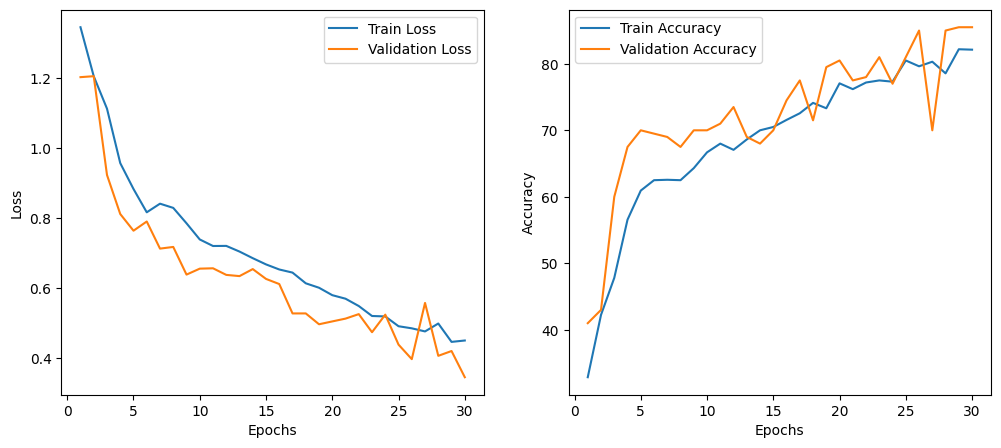

In [46]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label = "Train Loss")
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label = "Train Accuracy")
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [47]:
def prediction(model, val_loader):

    model.eval()
    model.to(DEVICE)

    all_images, all_labels = [], []
    all_pred_indices, all_pred_probs = [], []

    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.inference_mode():
             outputs = model(images)

        prob = F.softmax(outputs,dim=1)
        pred_indices = prob.data.max(dim=1)[1]
        pred_probs = prob.data.max(dim=1)[0]

        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_pred_indices.append(pred_indices.cpu())
        all_pred_probs.append(pred_probs.cpu())


    return (torch.cat(all_images).numpy(),
            torch.cat(all_labels).numpy(),
            torch.cat(all_pred_indices).numpy(),
            torch.cat(all_pred_probs).numpy())

In [48]:
def denormalize(image):
    mean_ar = np.array(MEAN).reshape(1,1,3)    # (1,1,3) for broadcasting over H,W
    std_ar  = np.array(STD).reshape(1,1,3)
    # image is (H,W,C) with normalized values: (orig - mean)/std
    image = (image * std_ar) + mean_ar         # now in 0..255 range
    image = image / 255.0                      # scale to 0..1 for plt.imshow
    return np.clip(image, 0.0, 1.0)

In [49]:
import random
import math

def visualise_predictions(sample_images,sample_gt_labels, pred_indices, pred_probs, num_images =5):

    num_cols = 4
    num_rows = math.ceil(num_images / num_cols)
    fig = plt.figure(figsize = (4*num_rows,3*num_cols))

    for i in range(num_images):
        idx = random.randint(0, len(sample_images) -1)
        image = sample_images[idx].transpose(1,2,0) #(C,H,W) --> (H,W,C)
        label = sample_gt_labels[idx]
        pred_idx = pred_indices[idx]
        pred_prob = pred_probs[idx]

        image = denormalize(image)

        ax = fig.add_subplot(num_rows, num_cols, i+1)
        ax.imshow(image)
        ax.set_title(f"GT: {class_mapping[label]}\nPred: {class_mapping[pred_idx]} ({pred_prob:.2f})")
        ax.axis('off')

    plt.show()

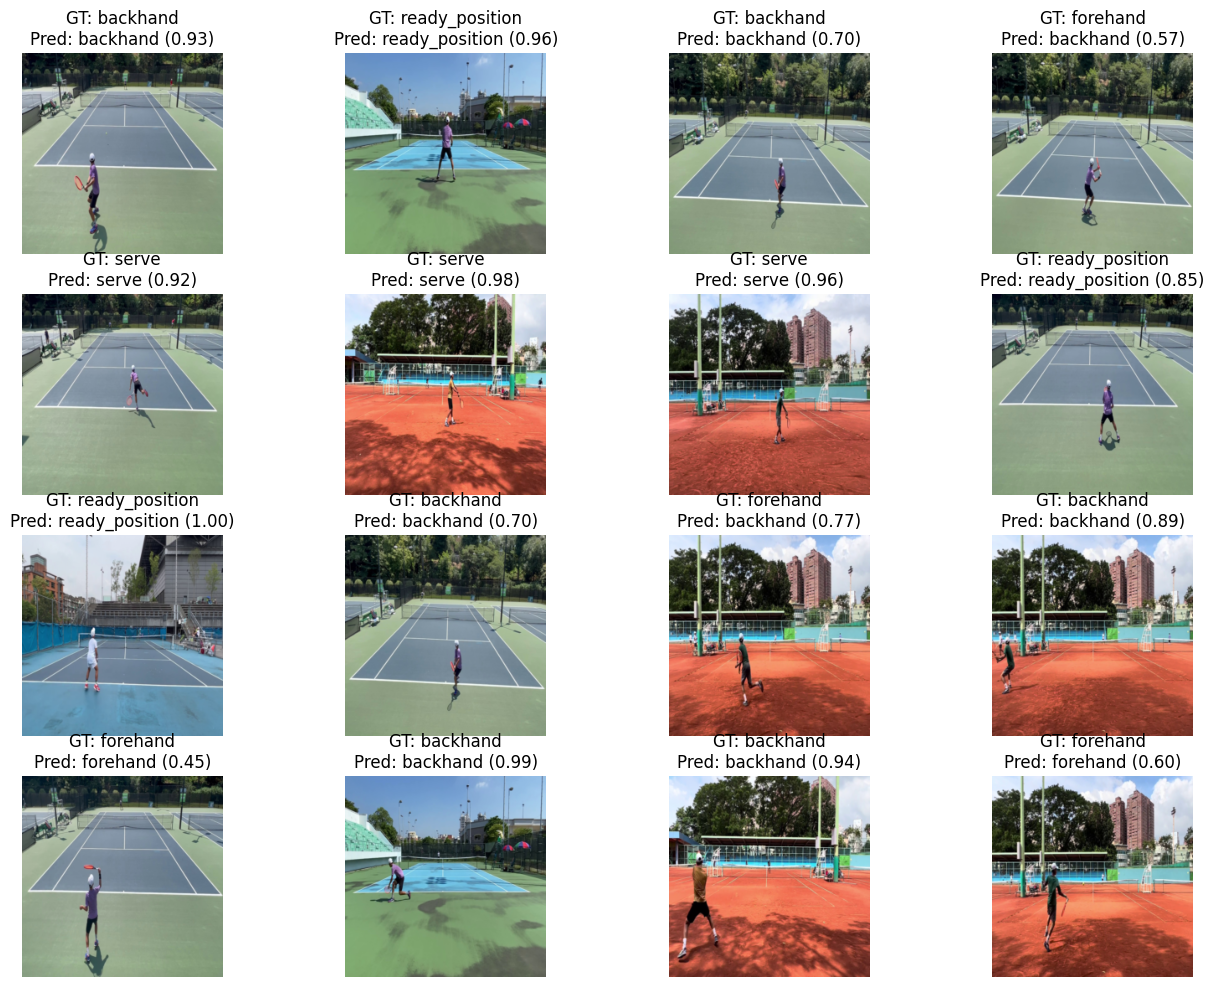

In [50]:
val_images, val_gt_labels, pred_indices, pred_probs = prediction(model, val_loader)

visualise_predictions(val_images, val_gt_labels, pred_indices, pred_probs, num_images = 16)

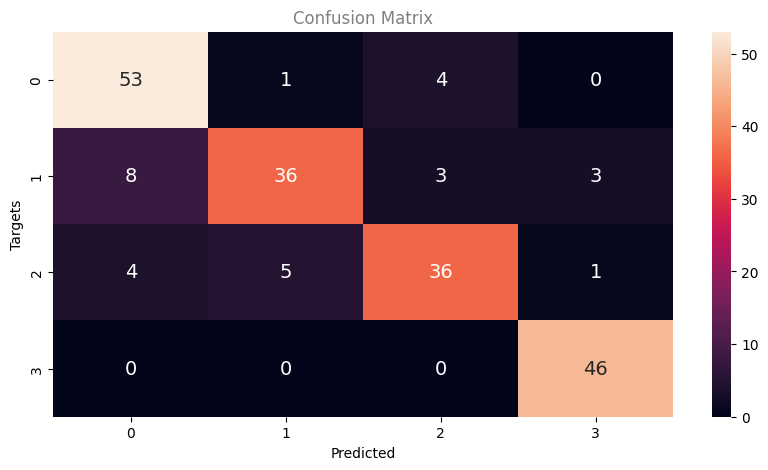

In [51]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=val_gt_labels, y_pred = pred_indices)

plt.figure(figsize= [10,5])
sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size":14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()

In [21]:
from torchvision import models
from torchinfo import summary

resnet = models.resnet34(weights='DEFAULT')
resnet = resnet.to(DEVICE)

print(summary(resnet, input_size=(BATCH_SIZE, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

In [19]:
print(f"Number of layer1 blocks: {len(resnet.layer1)}")
print(f"Number of layer2 blocks: {len(resnet.layer2)}")
print(f"Number of layer3 blocks: {len(resnet.layer3)}")
print(f"Number of layer4 blocks: {len(resnet.layer4)}")

Number of layer1 blocks: 3
Number of layer2 blocks: 4
Number of layer3 blocks: 6
Number of layer4 blocks: 3


In [10]:
# Change the final fully connected layer of the ResNet50 model for transfer learning
fc_inputs = resnet.fc.in_features  # Get the number of input features for the final layer

# Define a new fully connected layer with custom architecture for classification
resnet.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),  # Fully connected layer with 256 neurons
    nn.ReLU(),  # Apply ReLU activation
    nn.Dropout(0.3),  # Apply dropout with 40% probability to prevent overfitting
    nn.Linear(256, 4) # Output layer with number of classes as output neurons
)

# Move the model to the appropriate device (either CUDA or CPU)
resnet = resnet.to(DEVICE)

In [11]:
resnet_initial_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=False),
    v2.Normalize(mean=MEAN, std=STD),
    v2.Resize((240, 240)),
])

resnet_full_transform = v2.Compose([
    resnet_initial_transform,
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(DEGREES),
])

class TransformSubset(Dataset): 
    def __init__(self, subset, transform): 
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)
        
        
resnet_train_dataset = TransformSubset(train_dataset, resnet_full_transform)
resnet_test_dataset = TransformSubset(test_dataset, resnet_initial_transform)
resnet_val_dataset = TransformSubset(val_dataset, resnet_initial_transform)

resnet_train_loader = DataLoader(resnet_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
resnet_test_loader = DataLoader(resnet_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
resnet_val_loader = DataLoader(resnet_val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
NUM_EPOCHS=15


optimizer_resnet = torch.optim.Adam(resnet.parameters(), lr=1e-3)

train_losses, train_accuracies, val_losses, val_accuracies = main(resnet, resnet_train_loader, resnet_val_loader, NUM_EPOCHS, loss_fn, optimizer_resnet)

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch 01/15 - Train Loss: 1.3669, Train Accuracy: 32.50% - Val Loss: 1.2660, Val Accuracy: 40.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


Epoch 02/15 - Train Loss: 1.2519, Train Accuracy: 42.00% - Val Loss: 1.0335, Val Accuracy: 67.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch 03/15 - Train Loss: 1.2220, Train Accuracy: 44.69% - Val Loss: 1.0876, Val Accuracy: 49.00%


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch 04/15 - Train Loss: 1.2104, Train Accuracy: 44.50% - Val Loss: 0.9342, Val Accuracy: 69.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch 05/15 - Train Loss: 1.1479, Train Accuracy: 48.56% - Val Loss: 1.1012, Val Accuracy: 46.00%


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Epoch 06/15 - Train Loss: 1.1084, Train Accuracy: 51.75% - Val Loss: 0.8459, Val Accuracy: 65.00%


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch 07/15 - Train Loss: 1.1183, Train Accuracy: 50.44% - Val Loss: 1.0333, Val Accuracy: 50.50%


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Epoch 08/15 - Train Loss: 1.0785, Train Accuracy: 52.94% - Val Loss: 0.7804, Val Accuracy: 67.50%


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch 09/15 - Train Loss: 1.0773, Train Accuracy: 52.81% - Val Loss: 0.8514, Val Accuracy: 63.00%


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch 10/15 - Train Loss: 1.0645, Train Accuracy: 53.44% - Val Loss: 0.8775, Val Accuracy: 63.50%


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch 11/15 - Train Loss: 1.0680, Train Accuracy: 52.50% - Val Loss: 0.8006, Val Accuracy: 68.50%


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch 12/15 - Train Loss: 1.0541, Train Accuracy: 54.19% - Val Loss: 0.8015, Val Accuracy: 66.00%


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Epoch 13/15 - Train Loss: 1.0314, Train Accuracy: 55.31% - Val Loss: 0.7799, Val Accuracy: 65.00%


Training:  22%|██▏       | 11/50 [00:09<00:34,  1.12it/s]


KeyboardInterrupt: 

In [52]:
from torchvision.models import mobilenet_v3_small

# Load the model
mobilenetv3_model = mobilenet_v3_small(weights="DEFAULT")

# Number of feature layers
num_feature_layers = len(mobilenetv3_model.features)
print(f"Number of feature layers: {num_feature_layers}")

# Number of classifier layers
num_classifier_layers = len(mobilenetv3_model.classifier)
print(f"Number of classifier layers: {num_classifier_layers}")

Number of feature layers: 13
Number of classifier layers: 4


In [53]:
#Set requires_grad to True for all model parameters to allow training
# Freeze the earlier layers to retain pretrained low-level features
for param in mobilenetv3_model.features[:10].parameters():  # Adjust as needed
    param.requires_grad = False

In [54]:
mobilenetv3_model.classifier[3] = nn.Linear(in_features = 1024, out_features = 4, bias = True)

# Check the final classifier after modifications
print(mobilenetv3_model.classifier[3])

model = mobilenetv3_model
model = model.to(DEVICE)

Linear(in_features=1024, out_features=4, bias=True)


In [55]:
initial_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=False),
    v2.Normalize(mean=MEAN, std=STD),
    v2.Resize((240, 240)),
])

full_transform = v2.Compose([
    initial_transform,
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(DEGREES),
])

class TransformSubset(Dataset): 
    def __init__(self, subset, transform): 
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)
        
train_dataset, test_dataset, val_dataset = random_split(full_dataset, DATA_SPLIT, generator=generator)

train_dataset = TransformSubset(train_dataset, full_transform)
test_dataset = TransformSubset(test_dataset, initial_transform)
val_dataset = TransformSubset(val_dataset, initial_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [56]:
NUM_EPOCHS=30
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, train_accuracies, val_losses, val_accuracies = main(model, train_loader, val_loader, NUM_EPOCHS, loss_fn, optimizer)

Validation: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch 01/30 - Train Loss: 0.9059, Train Accuracy: 61.50% - Val Loss: 1.1130, Val Accuracy: 58.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch 02/30 - Train Loss: 0.4941, Train Accuracy: 79.88% - Val Loss: 0.9024, Val Accuracy: 73.50%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


Epoch 03/30 - Train Loss: 0.4630, Train Accuracy: 81.19% - Val Loss: 0.6355, Val Accuracy: 83.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


Epoch 04/30 - Train Loss: 0.3348, Train Accuracy: 86.88% - Val Loss: 0.4263, Val Accuracy: 85.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


Epoch 05/30 - Train Loss: 0.3060, Train Accuracy: 88.62% - Val Loss: 0.2869, Val Accuracy: 87.50%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Epoch 06/30 - Train Loss: 0.2707, Train Accuracy: 89.62% - Val Loss: 0.3461, Val Accuracy: 87.50%


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch 07/30 - Train Loss: 0.2313, Train Accuracy: 91.25% - Val Loss: 0.2638, Val Accuracy: 92.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch 08/30 - Train Loss: 0.1942, Train Accuracy: 92.50% - Val Loss: 0.5189, Val Accuracy: 86.00%


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch 09/30 - Train Loss: 0.2208, Train Accuracy: 90.88% - Val Loss: 0.2788, Val Accuracy: 90.50%


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch 10/30 - Train Loss: 0.1731, Train Accuracy: 93.06% - Val Loss: 0.1496, Val Accuracy: 95.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch 11/30 - Train Loss: 0.1533, Train Accuracy: 94.19% - Val Loss: 0.2327, Val Accuracy: 90.00%


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch 12/30 - Train Loss: 0.1554, Train Accuracy: 94.25% - Val Loss: 0.2283, Val Accuracy: 91.50%


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


Epoch 13/30 - Train Loss: 0.1674, Train Accuracy: 93.62% - Val Loss: 0.1437, Val Accuracy: 94.00%


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


Epoch 14/30 - Train Loss: 0.1436, Train Accuracy: 95.12% - Val Loss: 0.2204, Val Accuracy: 90.50%


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


Epoch 15/30 - Train Loss: 0.1258, Train Accuracy: 95.50% - Val Loss: 0.1745, Val Accuracy: 94.50%


Validation: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch 16/30 - Train Loss: 0.1128, Train Accuracy: 95.31% - Val Loss: 0.3646, Val Accuracy: 88.00%


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch 17/30 - Train Loss: 0.1176, Train Accuracy: 96.00% - Val Loss: 0.2393, Val Accuracy: 91.50%


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch 18/30 - Train Loss: 0.1211, Train Accuracy: 95.75% - Val Loss: 0.2373, Val Accuracy: 92.50%


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch 19/30 - Train Loss: 0.1227, Train Accuracy: 95.94% - Val Loss: 0.1879, Val Accuracy: 94.50%


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


Epoch 20/30 - Train Loss: 0.0906, Train Accuracy: 96.50% - Val Loss: 0.2405, Val Accuracy: 92.00%


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch 21/30 - Train Loss: 0.0896, Train Accuracy: 96.44% - Val Loss: 0.1933, Val Accuracy: 93.50%


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch 22/30 - Train Loss: 0.1063, Train Accuracy: 96.38% - Val Loss: 0.1996, Val Accuracy: 93.00%


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch 23/30 - Train Loss: 0.0984, Train Accuracy: 96.38% - Val Loss: 0.1715, Val Accuracy: 94.50%


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch 24/30 - Train Loss: 0.0872, Train Accuracy: 97.00% - Val Loss: 0.2088, Val Accuracy: 93.00%


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch 25/30 - Train Loss: 0.0913, Train Accuracy: 96.31% - Val Loss: 0.1282, Val Accuracy: 96.00%
Saving best model...💾


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch 26/30 - Train Loss: 0.0724, Train Accuracy: 97.50% - Val Loss: 0.3055, Val Accuracy: 93.50%


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch 27/30 - Train Loss: 0.0772, Train Accuracy: 97.06% - Val Loss: 0.1479, Val Accuracy: 95.50%


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch 28/30 - Train Loss: 0.0668, Train Accuracy: 97.62% - Val Loss: 0.1824, Val Accuracy: 95.00%


Validation: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch 29/30 - Train Loss: 0.0898, Train Accuracy: 97.25% - Val Loss: 0.2565, Val Accuracy: 90.00%


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]

Epoch 30/30 - Train Loss: 0.0892, Train Accuracy: 96.62% - Val Loss: 0.1800, Val Accuracy: 92.50%


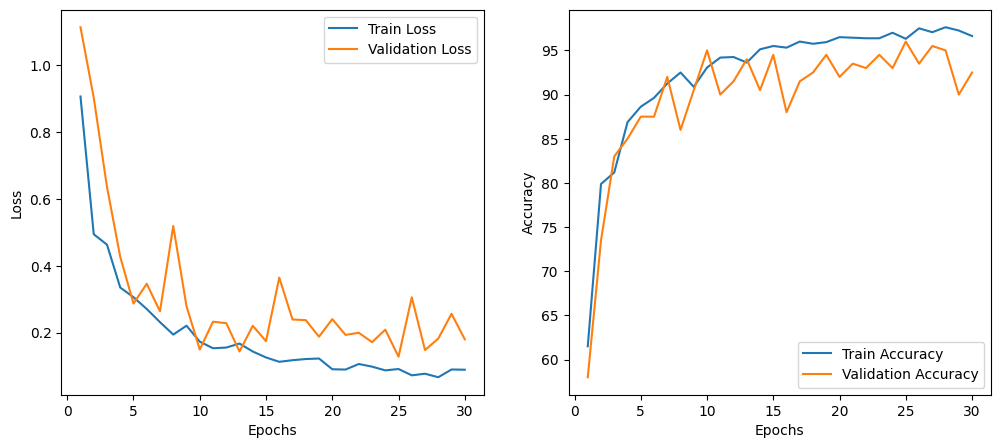

In [57]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label = "Train Loss")
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label = "Train Accuracy")
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

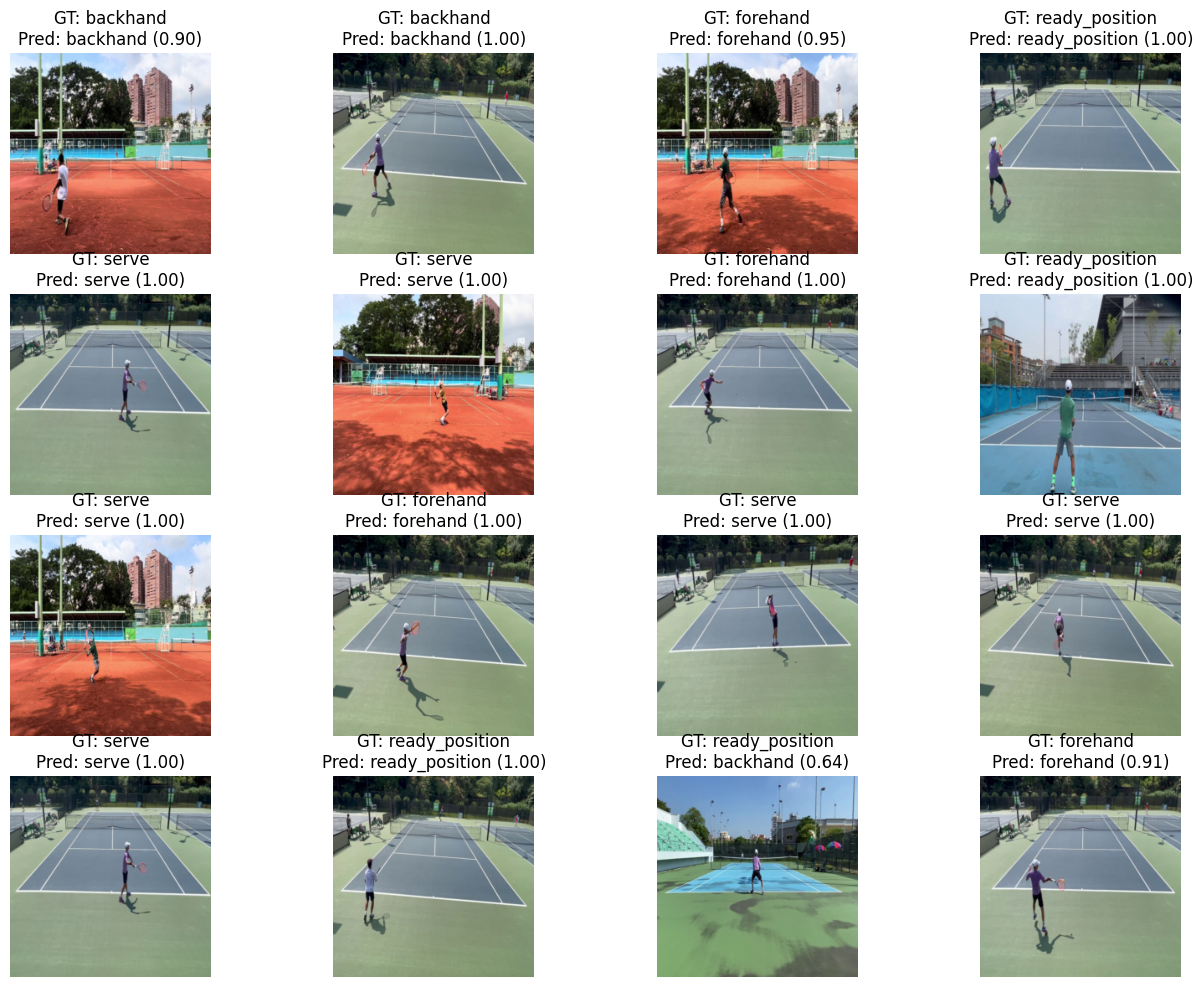

In [58]:
val_images, val_gt_labels, pred_indices, pred_probs = prediction(model, val_loader)

visualise_predictions(val_images, val_gt_labels, pred_indices, pred_probs, num_images = 16)

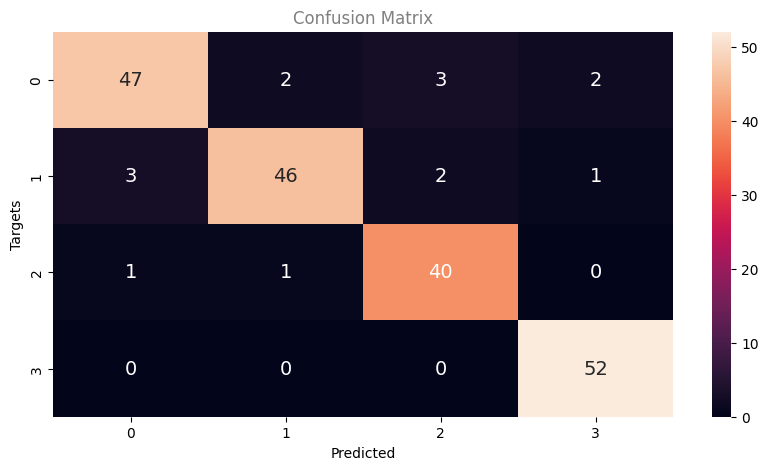

In [59]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=val_gt_labels, y_pred = pred_indices)

plt.figure(figsize= [10,5])
sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size":14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()